# PASA - TP3 - Predicción lineal

## Herrera Sebastian 61457

## Batinic Rey Joaquin 60416

In [1]:
import numpy as np
from scipy.signal import correlate, welch, freqz, butter, lfilter
import scipy.signal as signal
from scipy.fft import fft
from scipy.io import wavfile as wav
import scipy.linalg as linalg
import scipy.io.wavfile
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from arch.unitroot import ADF, PhillipsPerron, KPSS
from IPython.display import Audio
from pydub import AudioSegment
from statsmodels.tsa.filters.filtertools import recursive_filter

c:\Users\joaco\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
def EsEstacionario(signal, alpha):
  #PhillipsPerron Test
  phpr_result = PhillipsPerron(signal)
  phpr_p_value = phpr_result.pvalue
  phpr_test_result = "Stationary" if phpr_p_value < alpha else "Not stationary"
  print("PhillipsPerron Test:", phpr_test_result)
  # Augmented Dickey-Fuller Test
  adf_result = ADF(signal)
  adf_p_value = adf_result.pvalue
  adf_test_result = "Stationary" if adf_p_value < alpha else "Not stationary"
  print("Augmented Dickey-Fuller Test:", adf_test_result)
  # Kwiatkowski-Phillips-Schmidt-Shin Test
  kpss_result = KPSS(signal, lags=-1)
  kpss_p_value = kpss_result.pvalue
  kpss_test_result = "Stationary" if kpss_p_value > alpha else "Not stationary"
  print("Kwiatkowski-Phillips-Schmidt-Shin Test:", kpss_test_result)

In [2]:
original_audio = AudioSegment.from_file("./a.wav")
nueva_frecuencia = 16000
audio_downsampled = original_audio.set_frame_rate(nueva_frecuencia)
audio_downsampled.export("./a_16khz.wav", format="wav")

original_audio = AudioSegment.from_file("./sh.wav")
nueva_frecuencia = 16000
audio_downsampled = original_audio.set_frame_rate(nueva_frecuencia)
audio_downsampled.export("./sh_16khz.wav", format="wav")

original_audio = AudioSegment.from_file("./test.wav")
nueva_frecuencia = 16000
audio_downsampled = original_audio.set_frame_rate(nueva_frecuencia)
audio_downsampled.export("./test_16khz.wav", format="wav")


<_io.BufferedRandom name='./test_16khz.wav'>

# Análisis exploratorio de las señales 


Más allá de que se buscó que la grabación sea lo más estable posible, se evalua estadísticamente con los tests de Phillips-Perron, Dickey-Fuller y Kwiatkowski-Phillips-Schmidt-Shin si efectivamente se puede considerar en términos prácticos a las señales como estacionarias. 

In [3]:
#Valor significativo: 
alpha = 0.05
#90% de confianza
a_sr, signal_a = wav.read("./a_16khz.wav")
sh_sr, signal_sh = wav.read("./sh_16khz.wav")

# Convertir a mono y normalizar
a_mono = np.mean(signal_a, axis=1)
sh_mono =  np.mean(signal_sh, axis=1)

a_mono = a_mono - np.mean(a_mono)
a_mono = a_mono / np.abs(np.argmax(a_mono))
a_mono = a_mono[1*16000:2*16000]
sh_mono = sh_mono - np.mean(sh_mono)
sh_mono = sh_mono / np.abs(np.argmax(sh_mono))
sh_mono = sh_mono[1*16000:2*16000]
signal_a_aux = a_mono.ravel()
signal_sh_aux = sh_mono.ravel()


In [6]:
EsEstacionario(signal_a_aux/np.max(abs(signal_a)), alpha)

PhillipsPerron Test: Stationary
Augmented Dickey-Fuller Test: Stationary
Kwiatkowski-Phillips-Schmidt-Shin Test: Stationary


In [7]:
EsEstacionario(signal_sh_aux/np.max(abs(signal_sh)), alpha)

PhillipsPerron Test: Stationary
Augmented Dickey-Fuller Test: Stationary
Kwiatkowski-Phillips-Schmidt-Shin Test: Stationary


También se realizaron espectrogramas de las señales para verificar visualmente las componentes de frecuencia principales de las mismas. 

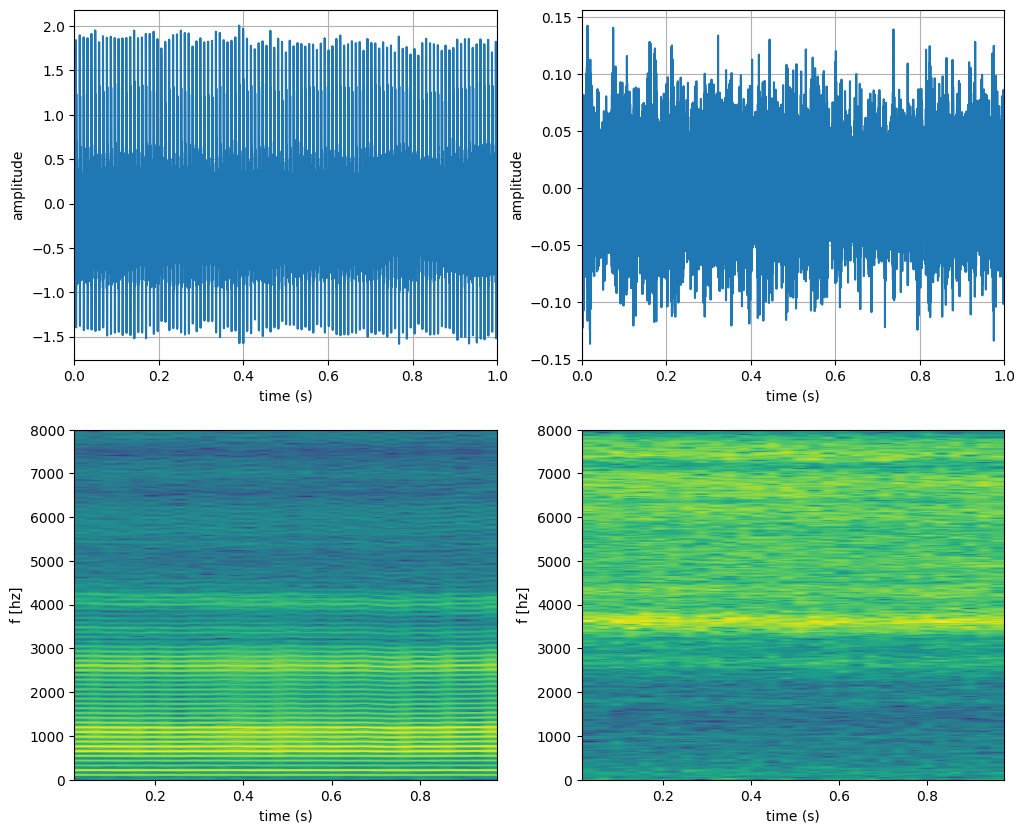

In [8]:
# Crear subgráficos
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].grid()
axs[0, 0].set_xlim(0, len(a_mono) / a_sr)
axs[0, 0].plot(np.arange(len(a_mono)) / a_sr, a_mono)
axs[0, 0].set_xlabel('time (s)')
axs[0,0].set_ylabel('amplitude')

axs[1, 0].specgram(a_mono, Fs=a_sr, cmap='viridis', NFFT=1024, noverlap=512)
axs[1,0].set_xlabel('time (s)')
axs[1,0].set_ylabel('f [hz]')
axs[0, 1].grid()
axs[0, 1].set_xlim(0, len(sh_mono) / sh_sr)
axs[0, 1].plot(np.arange(len(sh_mono)) / sh_sr, sh_mono)
axs[0, 1].set_xlabel('time (s)')
axs[0,1].set_ylabel('amplitude')
axs[1, 1].specgram(sh_mono, Fs=sh_sr, cmap='viridis', NFFT=1024, noverlap=512)
axs[1,1].set_xlabel('time (s)')
axs[1,1].set_ylabel('f [hz]')
plt.show()

Se procede a evaluar el error mínimo para diferentes órdenes de filtro. Es notorio que en el caso del fonema /sh/ el gráfico contiene solo un codo (aprox. en M=25),
mientras que para el fonema /a/ resulta haber dos (M=35 y M=160).

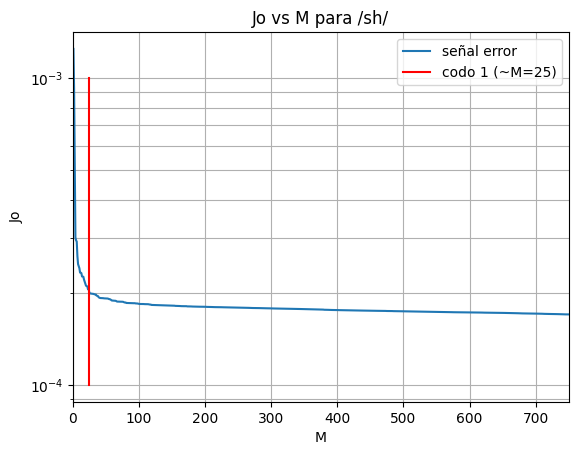

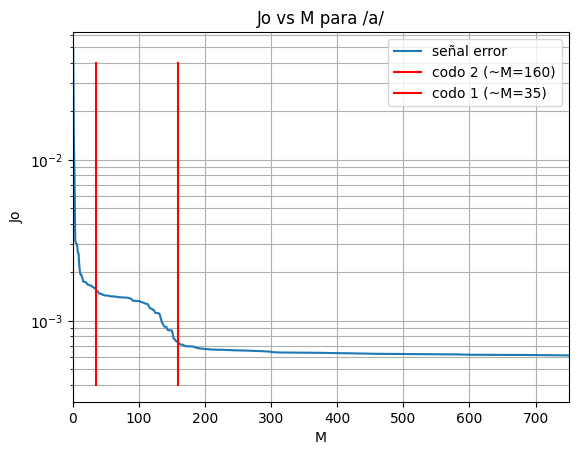

In [4]:
signal_a = a_mono
signal_sh = sh_mono

m_array = [i for i in range(1,1500)]
N = len(signal_sh)
r = correlate(signal_sh, signal_sh, 'full')[len(signal_sh)-1:] / len(signal_sh)
Jo_sh_array = []
a0_sh_array = []
for m in m_array:
    r_forward = np.conjugate(r[1:m+1]) 
    a0 = linalg.solve_toeplitz(r[:m], -1*r_forward)
    jo = r[0] + np.dot(r[1:m+1], np.transpose(a0))
    # Recopilamos los diferentes resultados en arrays para su posterior uso
    Jo_sh_array.append(jo)
    a0_sh_array.append(a0)

plt.title('Jo vs M para /sh/')
plt.xlabel('M')
plt.ylabel('Jo')
plt.xlim(0,750)
plt.grid(which='both')
plt.semilogy(m_array, Jo_sh_array,label = 'señal error')
plt.plot([25, 25], [1e-4,0.1e-2], 'r-', label = 'codo 1 (~M=25)')
plt.legend()
plt.show()

m_array = [i for i in range(1,2000)]
N = len(signal_a)
r = correlate(signal_a, signal_a, 'full')[len(signal_a)-1:] / len(signal_a)
Jo_a_array = []
a0_a_array = []
for m in m_array:
    r_forward = np.conj(r[1:m+1]) 
    a0 = linalg.solve_toeplitz(r[:m], -1*r_forward)
    jo = r[0] + np.dot(r[1:m+1], np.transpose(a0))
    Jo_a_array.append(jo)
    a0_a_array.append(a0)

plt.title('Jo vs M para /a/')
plt.xlabel('M')
plt.ylabel('Jo')
plt.xlim(0,750)
plt.grid(which='both')
plt.semilogy(m_array, Jo_a_array,label = 'señal error')
plt.plot([160, 160], [4e-4,4e-2], 'r-', label = 'codo 2 (~M=160)')
plt.plot([35, 35], [4e-4,4e-2], 'r-', label = 'codo 1 (~M=35)')
plt.legend()
plt.show()

Analizando el espectrograma de la señal correspondiente a /a/ notamos ciertas cuestiones. Primero, observando la PSD se puede notar que la señal /a/ contiene componentes periódicas. Esto es una diferencia respecto de la señal /sh/. Es evidente que cuando se entona el fonema /a/ debe haber un armónico principal seguido de una serie de armónicos acoplado a cierto nivel de ruido y que el fonema /sh/ tiene un comportamiento únicamente ruidoso. Esto se evidencia en los espectrogramas realizados. 

A continuación se muestran los periodogramas de las dos señales. 
Para el periodograma de /a/ son notorias tres cosas: 

1. El armónico principal de nuestra señal /a/ se encuentra aproximadamente en 148hz.  
2. El segundo codo (M~160) tiene una extensión que se corresponde con este armónico principal.
3. El primer codo (M~35) se corresponde con el punto a partir del cual aparece un nivel de energía no asociado al los armónicos.

Luego, observamos en la señal /sh/ el mismo fenómeno, donde el codo de ubica en el límite con la energía acumulada a altas frecuencias del que se compone la señal. 


<Figure size 600x200 with 0 Axes>

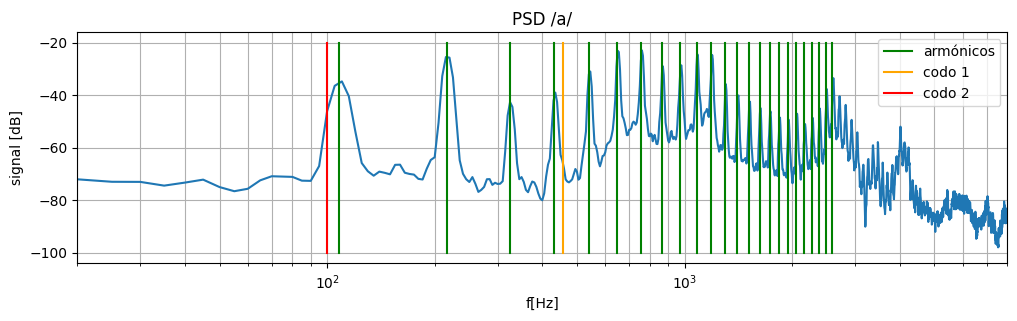

<Figure size 600x200 with 0 Axes>

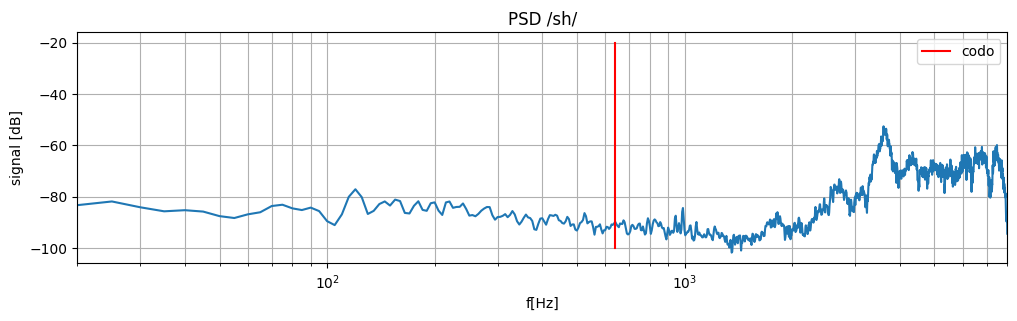

In [10]:
plt.figure(figsize=(6,2))
segnum = 5
f, Pxx_den = welch(signal_a, fs=16000, window='parzen', nperseg=len(signal_a)//segnum, noverlap=len(signal_a)//segnum//2, detrend='constant', return_onesided=True, scaling='density')

plt.figure(figsize=(12,3))
plt.semilogx(f, 10*np.log10(Pxx_den))
plt.title('PSD /a/')
plt.xlabel('f[Hz]')
plt.ylabel('signal [dB]')
plt.xlim(20,8000)
plt.grid(which='both')
codo1 = [16000/35, 16000/35]
armonicos = np.array([16000/148, 16000/148])

for i in range(1,25):
    if i==1:    
        plt.plot(i*armonicos, [-100, -20], 'g', label='armónicos')
    else:
        plt.plot(i*armonicos, [-100, -20], 'g')

plt.plot(codo1, [-100, -20], 'orange', label = 'codo 1')
plt.plot([16000/160, 16000/160], [-100, -20], 'r', label = 'codo 2')

plt.legend()
plt.show()

plt.figure(figsize=(6,2))
segnum = 5
f, Pxx_den = welch(signal_sh, fs=16000, window='parzen', nperseg=len(signal_sh)//segnum, noverlap=len(signal_sh)//segnum//2, detrend='constant', return_onesided=True, scaling='density')

plt.figure(figsize=(12,3))
plt.semilogx(f, 10*np.log10(Pxx_den))
plt.title('PSD /sh/')
plt.xlabel('f[Hz]')
plt.ylabel('signal [dB]')
plt.xlim(20,8000)
plt.grid(which='both')
codo1 = [16000/25, 16000/25]

plt.plot(codo1, [-100, -20], 'r', label = 'codo')


plt.legend()
plt.show()

Como se aprecia en los gráficos a continuación de este texto, cuando M es 1 la PSD del error es prácticamente igual a la señal de entrada, lógicamente. A medida que M aumenta, las componentes de mayor frecuencia comienzan a desaparecer del error ya que esa información empieza a ser incorporada al filtro. Este comportamiento explica la naturaleza de los dos codos de Jo. El primer codo se debe a la energía acumulada en frecuencias medias y altas de la señal y pasando el segundo codo también se incorpora la información de los primeros armónicos. Esto se aprecia en el gráfico de la PSD que se ubica antes de este texto, donde se ubica la posición de los codos en frecuencia. A medida que M aumenta, se aprecia un mayor efecto whitening. Sin embargo, en frecuencias bajas el espectro cae por no tener la señal original energía significativa en aquellas bandas. 

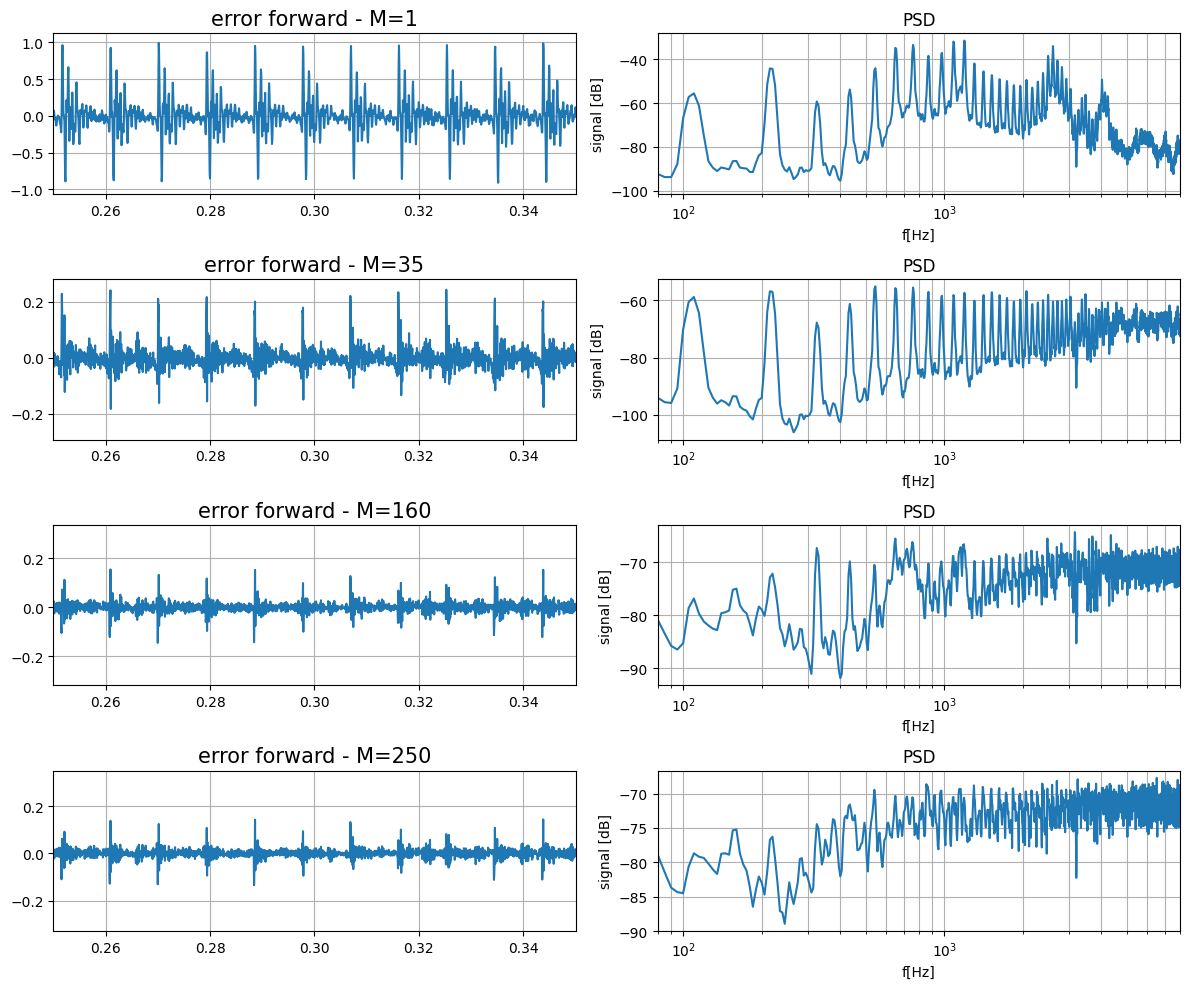

In [10]:
def analyze_e_f(i, ax, M = 250):
    a_error = np.concatenate(([1], a0_a_array[M-1]))
    error_forward = signal.lfilter(a_error, [1], signal_a)[:len(signal_a)]
    #error_forward = np.convolve(signal_a, a_error, mode='full')[:len(signal_a)]

    ax[i, 0].set_title('error forward - M=' + str(M), fontsize=15)
    ax[i, 0].plot(np.arange(len(error_forward))/16000,error_forward)
    ax[i, 0].set_xlim(0.25,0.35)
    ax[i, 0].grid(which='both')

    segnum = 5
    f, Pxx_den = welch(error_forward, fs=16000, window='parzen', nperseg=len(error_forward)//segnum, noverlap=len(error_forward)//segnum//2, detrend='constant', return_onesided=True, scaling='density')


    ax[i, 1].semilogx(f, 10*np.log10(Pxx_den))
    ax[i, 1].set_title('PSD')
    ax[i, 1].set_xlabel('f[Hz]')
    ax[i, 1].set_ylabel('signal [dB]')
    ax[i, 1].set_xlim(80,8000)
    ax[i, 1].grid(which='both')
    return i+1

m_arr = [1,35, 160, 250]
i = 0
fig, ax = plt.subplots(len(m_arr), 2, figsize=(12, 10)) 
for m in m_arr:
    i = analyze_e_f(i, ax, m)
fig.tight_layout()
plt.show()

# Punto 3

A continuación se muestra la respuesta en frecuencia de los filtros error a medida que M crece. También se grafica la inversa de la FFT de la señal. Asi, se aprecia claramente que a medida que M crece el error pierde información de frecuencias cada vez más bajas, ya que la misma pasa a poder ser incorporada por el filtro. Puesto en otros términos, como se apreció en el punto anterior para M cada vez más grande el filtro se aproxima al segundo codo y la señal error se aproxima cada vez más a tener un espectro plano, y esto se refleja en que el filtro error se aproxima cada vez más a la inversa de la respuesta en frecuencia de la señal. 

In [12]:
m_array = [1, 2, 4, 8, 16, 32, 64]

a_arr_a = [np.concatenate(([1],a0_a_array[1-1])),
         np.concatenate(([1],a0_a_array[2-1])),
         np.concatenate(([1],a0_a_array[4-1])),
         np.concatenate(([1],a0_a_array[8-1])),
         np.concatenate(([1],a0_a_array[16-1])),
         np.concatenate(([1],a0_a_array[32-1])),
         np.concatenate(([1],a0_a_array[64-1]))]

a_arr_sh = [np.concatenate(([1],a0_sh_array[1-1])),
            np.concatenate(([1],a0_sh_array[2-1])),
            np.concatenate(([1],a0_sh_array[4-1])),
            np.concatenate(([1],a0_sh_array[8-1])),
            np.concatenate(([1],a0_sh_array[16-1])),
            np.concatenate(([1],a0_sh_array[32-1])),
            np.concatenate(([1],a0_sh_array[64-1]))]




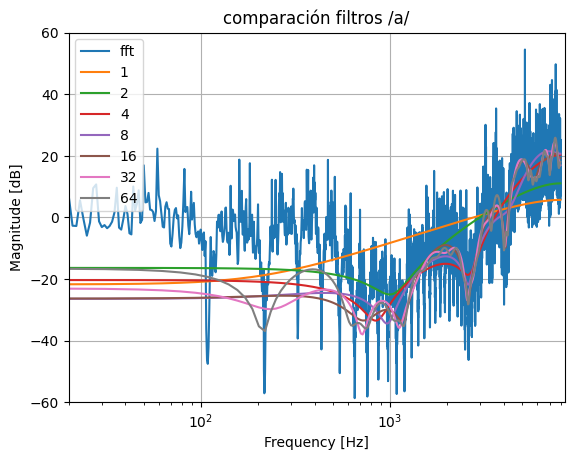

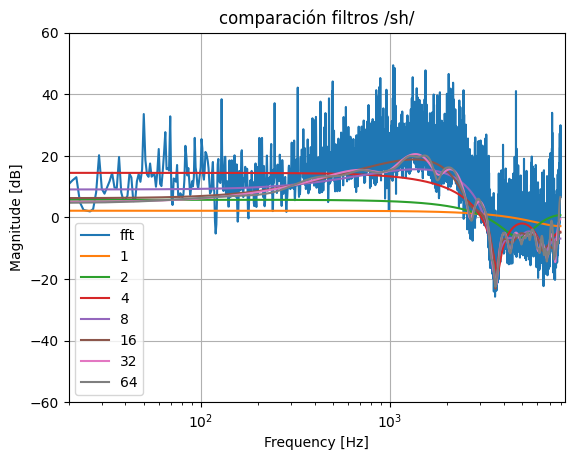

In [13]:
#Señal a

win = signal.get_window('parzen', len(signal_a))
fft_result = np.fft.fft(win*signal_a)

frequencies = np.fft.fftfreq(len(fft_result), 1/16000)
frequencies = frequencies[:len(frequencies)//2-1]
fft_result = fft_result[:len(fft_result)//2-1:]
plt.plot(frequencies, 20 * np.log10(np.abs(1/fft_result)), label= 'fft')
plt.xlim(20,)
plt.ylim(-60,60)

for i, a in enumerate(a_arr_a):
    w, h = freqz(a, fs = 16000)
    plt.plot(w, 20 * np.log10(np.abs(h)), label= str(m_array[i]))


plt.title('comparación filtros /a/')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.semilogx()
plt.legend()
plt.show()

#Señal sh

win = signal.get_window('parzen', len(signal_sh))

fft_result = np.fft.fft(win*signal_sh)

frequencies = np.fft.fftfreq(len(fft_result), 1/16000)
frequencies = frequencies[:len(frequencies)//2-1]
fft_result = fft_result[:len(fft_result)//2-1:]
plt.plot(frequencies, 20 * np.log10(np.abs(1/fft_result)), label= 'fft')
plt.xlim(20,)
plt.ylim(-60,60)

for i, a in enumerate(a_arr_sh):
    w, h = freqz(a, fs = 16000)
    plt.plot(w, 20 * np.log10(np.abs(h)), label= str(m_array[i]))


plt.title('comparación filtros /sh/')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.semilogx()
plt.legend()
plt.show()

# Punto 4

Habiendo analizado las características de la señal error para un M correspondiente al final del primer codo (M=35) a continuación se la modela con un modelo estocástico. Para esto se eligió en particular un modelo AR para poder aproximar la señal a partir de ruido gaussiano. El orden propuesto para este modelo es 250 (es decir, luego del segundo codo) para poder capturar correctamente el comportamiento de todas las frecuencias hasta el armónico principal de la señal.

Para hacer esto se resuelven las ecuaciones de Yule-Walker para el orden propuesto, y finalmente se filtra la señal error con el filtro inverso al filtro error, para poder crear una estimación de la señal original. Consideramos que nuestro modelado es apropiado si se obtiene una señal semejante al audio de /a/ original, particularmente en sus armónicos. 

Efectivamente, analizando los periodogramas del audio original y la síntesis a partir de ruido blanco, se observa una gran similitud entre los mismos, tanto en potencia como la ubicación de sus armónicos. La mayor diferencia radica en el mayor piso de ruido exhibido por la aproximación. Además, la potencia exacta de los picos espectrales depende de cada ejecución del modelo. Esto es lógico, dado que la longitud de la señal generada, que es corta, y al naturaleza estocástica del modelo.

En definitiva, dados los requerimientos planteados, consideramos que el modelado es apropiado y que el filtro error se comporta como es de esperar. 

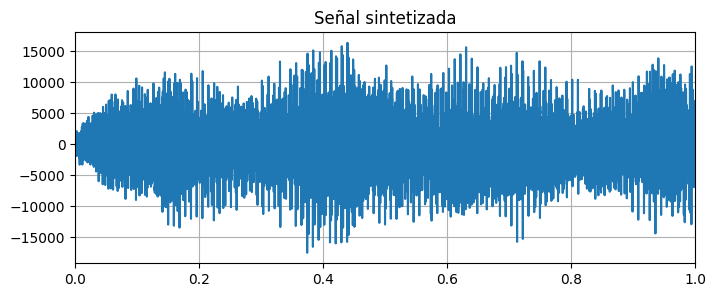

In [57]:
#Para la señal de error utilizamos un M de orden 25, para que quede despues del 1er codo

M = 35
a_aux = a0_a_array[M]
a_error = np.concatenate(([1], a_aux))
error_forward = signal.lfilter(a_error, [1], signal_a)
# Sacamos la autocorrelación del error
error_forward_corr = correlate(error_forward, error_forward, method='fft', mode='same')[len(error_forward)//2:] / (len(error_forward))

# Usamos un modelo de orden 350 para poder capturar los armónicos más bajos de la señal ruido 
ar_order = 250

# Resolvemos las ecuaciones de Yule Walker
R = error_forward_corr[:ar_order]
r = error_forward_corr[1:ar_order+1]
a_ar = linalg.solve_toeplitz(R, -r)

# Sintetizamos un simil de la señal de error a partir de ruido blanco
# llamamos a esta señal sintetizada como synthetic error
synthetic_error = signal.lfilter([1], np.concatenate(([1], a_ar)), np.random.normal(size=len(signal_a)))

#Hacemos el filtrado inverso de la señal de error sintetizada
synthetic_signal = signal.lfilter([1], a_error, synthetic_error) 

#normalizamos la señal generada para el wav
synthetic_signal = np.int16(synthetic_signal*32767/(2*np.max(synthetic_signal)))
signal_a_normalized = np.int16(signal_a*32767/(2*np.max(signal_a)))

plt.figure(figsize=(8, 3))
plt.grid(which='both')
plt.title('Señal sintetizada')
plt.xlim(0, len(synthetic_signal) / a_sr)
plt.plot(np.arange(len(synthetic_signal)) / a_sr, synthetic_signal)
plt.show()



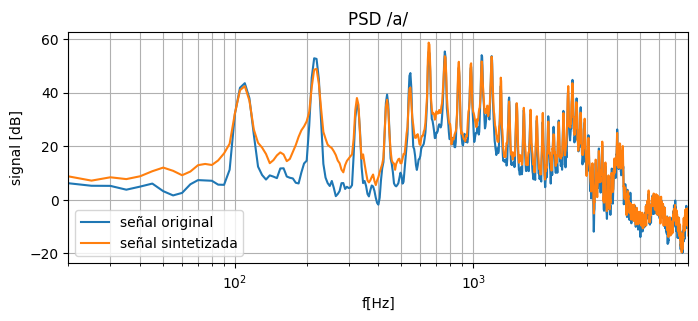

In [58]:
segnum = 5
f_synth, Pxx_den_synth = welch(synthetic_signal, fs=16000, window='parzen', nperseg=len(synthetic_signal)//segnum, noverlap=len(synthetic_signal)//segnum//2, detrend='constant', return_onesided=True, scaling='density')
f_original, Pxx_den_original = welch(signal_a_normalized, fs=16000, window='parzen', nperseg=len(signal_a_normalized)//segnum, noverlap=len(signal_a_normalized)//segnum//2, detrend='constant', return_onesided=True, scaling='density')

plt.figure(figsize=(8, 3))
plt.title('PSD /a/')
plt.xlabel('f[Hz]')
plt.ylabel('signal [dB]')
plt.xlim(20,8000)
plt.grid(which='both')
plt.semilogx(f_original, 10*np.log10(Pxx_den_original), label='señal original')
plt.semilogx(f_synth, 10*np.log10(Pxx_den_synth), label='señal sintetizada')
plt.legend()
plt.show()

Los audios resultantes de la síntesis del error y del filtrado inverso son los siguientes:

Audio sintetizado:

In [16]:
from IPython.display import Audio
from scipy.io import wavfile
wavfile.write('./RESINTETIZADO_A.wav', 16000, synthetic_signal)
Audio('./RESINTETIZADO_A.wav')

Audio original:

In [17]:
wavfile.write('./1sfragsment_a.wav', 16000, signal_a)
Audio('./1sfragment_a.wav')

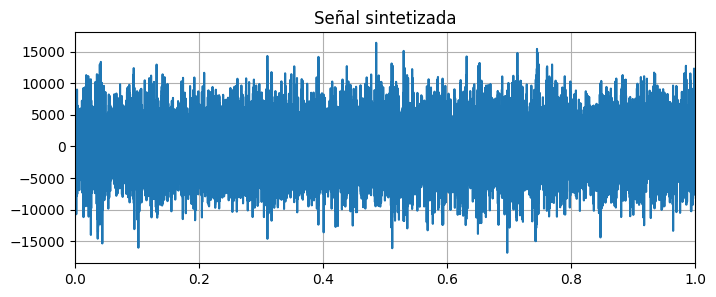

In [41]:
#Para la señal de error utilizamos un M de orden 25, para que quede despues del 1er codo

M = 25
a_aux = a0_sh_array[M]
a_error = np.concatenate(([1], a_aux))
error_forward = signal.lfilter(a_error, [1], signal_sh)
# Sacamos la autocorrelación del error
error_forward_corr = correlate(error_forward, error_forward, method='fft', mode='same')[len(error_forward)//2:] / (len(error_forward))

# Usamos un modelo de orden 350 para poder capturar los armónicos más bajos de la señal ruido 
ar_order = 500

# Resolvemos las ecuaciones de Yule Walker
R = error_forward_corr[:ar_order]
r = error_forward_corr[1:ar_order+1]
a_ar = linalg.solve_toeplitz(R, -r)

# Sintetizamos un simil de la señal de error a partir de ruido blanco
# llamamos a esta señal sintetizada como synthetic error
synthetic_error = signal.lfilter([1], np.concatenate(([1], a_ar)), np.random.normal(size=len(signal_a)))

#Hacemos el filtrado inverso de la señal de error sintetizada
synthetic_signal = signal.lfilter([1], a_error, synthetic_error) 

#normalizamos la señal generada para el wav
synthetic_signal = np.int16(synthetic_signal*32767/(2*np.max(synthetic_signal)))
signal_sh_normalized = np.int16(signal_sh*32767/(2*np.max(signal_sh)))

plt.figure(figsize=(8, 3))
plt.grid(which='both')
plt.title('Señal sintetizada')
plt.xlim(0, len(synthetic_signal) / a_sr)
plt.plot(np.arange(len(synthetic_signal)) / a_sr, synthetic_signal)
plt.show()



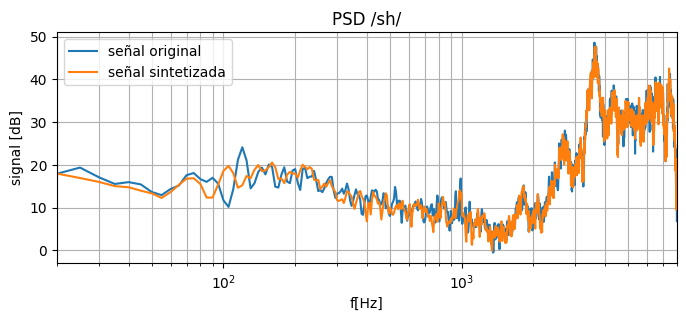

In [19]:
segnum = 5
f_synth, Pxx_den_synth = welch(synthetic_signal, fs=16000, window='parzen', nperseg=len(synthetic_signal)//segnum, noverlap=len(synthetic_signal)//segnum//2, detrend='constant', return_onesided=True, scaling='density')
f_original, Pxx_den_original = welch(signal_sh_normalized, fs=16000, window='parzen', nperseg=len(signal_a_normalized)//segnum, noverlap=len(signal_a_normalized)//segnum//2, detrend='constant', return_onesided=True, scaling='density')

plt.figure(figsize=(8, 3))
plt.title('PSD /sh/')
plt.xlabel('f[Hz]')
plt.ylabel('signal [dB]')
plt.xlim(20,8000)
plt.grid(which='both')
plt.semilogx(f_original, 10*np.log10(Pxx_den_original), label='señal original')
plt.semilogx(f_synth, 10*np.log10(Pxx_den_synth), label='señal sintetizada')
plt.legend()
plt.show()

Los audios resultantes de la síntesis del error y del filtrado inverso son los siguientes:

Audio sintetizado:

In [20]:
from IPython.display import Audio
from scipy.io import wavfile
wavfile.write('./RESINTETIZADO_SH.wav', 16000, synthetic_signal)
Audio('./RESINTETIZADO_SH.wav')

Audio original:

In [26]:
wavfile.write('./1sfragment_sh.wav', 16000, signal_sh)
Audio('./1sfragment_sh.wav')

Para corroborar que el error se este calculando correctamente, procedemos a aplicar el filtro inverso sobre el error de manera que debemos obtener a la salida la misma señal original. Se procede a escucharlo y, efectivamente, podemos confirmar que es lo mismo y que el filtro no introduce distorsiones.

In [61]:
M = 12
a_aux = a0_a_array[M]
a_error = np.concatenate(([1], a_aux))
error_forward = signal.lfilter(a_error, [1], signal_a)
new_sig = signal.lfilter([1], a_error, error_forward) 


wavfile.write('./RESINTETIZADO_AV3.wav', 16000, np.int16(new_sig*32767/(2*np.max(new_sig))))
print('audio filtrado y refiltrado: ')
Audio('./RESINTETIZADO_AV3.wav')

audio filtrado y refiltrado: 


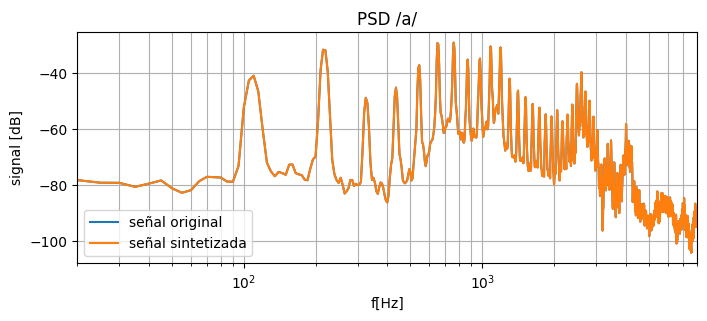

In [63]:
segnum = 5
f_synth, Pxx_den_synth = welch(signal_a/np.max(signal_a), fs=16000, window='parzen', nperseg=len(signal_a)//segnum, noverlap=len(signal_a)//segnum//2, detrend='constant', return_onesided=True, scaling='density')
f_original, Pxx_den_original = welch(new_sig/np.max(new_sig), fs=16000, window='parzen', nperseg=len(new_sig)//segnum, noverlap=len(new_sig)//segnum//2, detrend='constant', return_onesided=True, scaling='density')

plt.figure(figsize=(8, 3))
plt.title('PSD /a/')
plt.xlabel('f[Hz]')
plt.ylabel('signal [dB]')
plt.xlim(20,8000)
plt.grid(which='both')
plt.semilogx(f_original, 10*np.log10(Pxx_den_original), label='señal original')
plt.semilogx(f_synth, 10*np.log10(Pxx_den_synth), label='señal sintetizada')
plt.legend()
plt.show()

# Punto 5

En esta seccion se procede a realizar una versión básica de un vocoder. Se resintetiza una grabación de mayor longitud, filtrando un tren de pulsos con el filtro error de cada fragmento de 50ms de la señal original. Primero se filtró, como se especifica en la consigna, con un filtro error de orden 12. Luego, con un M (M=35) mayor, que a nuestro juicio brinda acústicamente resultados más agradables.

In [66]:
Audio('./test_16khz.wav')

In [67]:
original_audio = AudioSegment.from_file("./test.wav")
nueva_frecuencia = 16000
audio_downsampled = original_audio.set_frame_rate(nueva_frecuencia)
audio_downsampled.export("./test_16khz.wav", format="wav")

<_io.BufferedRandom name='./test_16khz.wav'>

In [68]:
ds_sr, discurso = wav.read("./test_16khz.wav")
discurso = discurso - np.mean(discurso)
discurso = discurso / np.abs(np.argmax(discurso))
discurso = np.mean(discurso, axis=1)

M = 12

In [70]:
ventana_longitud = int(ds_sr * 0.05)  # 50 ms en muestras

overlap = ventana_longitud // 2  # 50% de superposición
senal_final = np.zeros(len(discurso))

M = 12
fs_impulsos = 160  # Hz
impulsos = [1 if (j%100==0) else 0 for j in range(len(discurso))]
ventana = np.hanning(ventana_longitud)

for i in range(0, len(discurso) - ventana_longitud, ventana_longitud - overlap):
    # Se toma un bloque segmentado de la grabación y se aplica la ventana de Hann
    bloque_signal = discurso[i:i + ventana_longitud] 
    bloque_signal *= ventana
    # Calculamos el error de prediccion
    r = correlate(bloque_signal, bloque_signal, 'full')[len(bloque_signal)-1:] / len(bloque_signal)
    r_forward = np.conj(r[1:M]) 
    a0 = linalg.solve_toeplitz(r[:M-1], -1*r_forward)
    a_error = np.concatenate(([1], a0[:M])) 
    # Aplicamos el filtrado con el tren de impulsos al error
    bloque_error = signal.lfilter([1], a_error, impulsos[i:i+ventana_longitud])
    # Conformamos la señal final con el procesamiento de todos estos bloques
    senal_final[i:i + ventana_longitud] += bloque_error

wavfile.write('./discurso_sintetizado_m12.wav', 16000, np.int16(senal_final*32767/(np.max(senal_final))))
Audio('./discurso_sintetizado_m12.wav')

M = 35

In [71]:
ventana_longitud = int(ds_sr * 0.05)  # 50 ms en muestras

overlap = ventana_longitud // 2  # 50% de superposición
senal_final = np.zeros(len(discurso))

M = 35
fs_impulsos = 160  # Hz
impulsos = [1 if (j%100==0) else 0 for j in range(len(discurso))]
ventana = np.hanning(ventana_longitud)

for i in range(0, len(discurso) - ventana_longitud, ventana_longitud - overlap):
    # Se toma un bloque segmentado de la grabación y se aplica la ventana de Hann
    bloque_signal = discurso[i:i + ventana_longitud] 
    bloque_signal *= ventana
    # Calculamos el error de prediccion
    r = correlate(bloque_signal, bloque_signal, 'full')[len(bloque_signal)-1:] / len(bloque_signal)
    r_forward = np.conj(r[1:M]) 
    a0 = linalg.solve_toeplitz(r[:M-1], -1*r_forward)
    a_error = np.concatenate(([1], a0[:M])) 
    # Aplicamos el filtrado con el tren de impulsos al error
    bloque_error = signal.lfilter([1], a_error, impulsos[i:i+ventana_longitud])
    # Conformamos la señal final con el procesamiento de todos estos bloques
    senal_final[i:i + ventana_longitud] += bloque_error

wavfile.write('./discurso_sintetizado_m25.wav', 16000, np.int16(senal_final*32767/(np.max(senal_final))))
Audio('./discurso_sintetizado_m25.wav')